In [115]:
import pandas as pd
import numpy as np
from pathlib import Path
from dispatches_sample_data import rts_gmlc
from dispatches.case_studies.renewables_case.double_loop_utils import *

import matplotlib.pyplot as plt
plt.style.use('dark_background')

# rts_gmlc_dir = Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_10_reserves")
rts_gmlc_dir = Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_10_reserves_1000_shortfall_eagle")
rts_gmlc_dir = Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_10_reserves_500_shortfall_eagle")
# rts_gmlc_dir = Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_15_reserves_1000_shortfall_eagle")
# rts_gmlc_dir = Path("/Users/dguittet/Projects/Dispatches/workspace/prescient_runs/simulate_with_network_with_uncertainty_w_15_reserves_500_shortfall_eagle")
rts_gmlc_dir = Path("/Users/dguittet/Projects/Dispatches/workspace/deterministic_with_network_simulation_output_year")

summary, gen_df = read_prescient_outputs(rts_gmlc_dir, rts_gmlc.source_data_path)


In [2]:
lmp_upper = 3

lowLMP_per_bus = {}
for bus in summary['Bus'].unique():
    df_bus = summary[summary['Bus'] == bus]
    low_price_lmps = df_bus[df_bus['LMP'] < lmp_upper]['LMP']
    lowLMP_per_bus[bus] = len(low_price_lmps)

lowLMP_per_bus = {k: v for k, v in sorted(lowLMP_per_bus.items(), key=lambda item: item[1])}
max_zeroLMP = max(v for k, v in lowLMP_per_bus.items())


Look at the wind plants and see where there is a lot of RT curtailment, that could potentially be shifted over via Hydrogen at low cost (< lmp_upper)

In [3]:
def plot_low_lmps(summary, bus, lmp_upper=3):
    df_bus = summary[summary['Bus'] == bus]
    low_rt_lmp_mask = df_bus['LMP'] < lmp_upper

    fig, ax = plt.subplots(1,1,figsize=(24, 4),sharex=True)
    df_resampled = df_bus.resample('1D').mean()
    df_resampled['low LMP'] = df_bus['LMP'] < lmp_upper

    ax.plot(df_resampled['LMP'])
    ax.set_ylabel("LMP RT $/MWh")
    ax = ax.twinx()
    ax.plot(df_resampled['low LMP'].cumsum(), color='g')
    ax.set_ylabel("Count of Low LMP hrs")
    plt.suptitle(f"RT LMPs at {bus}")

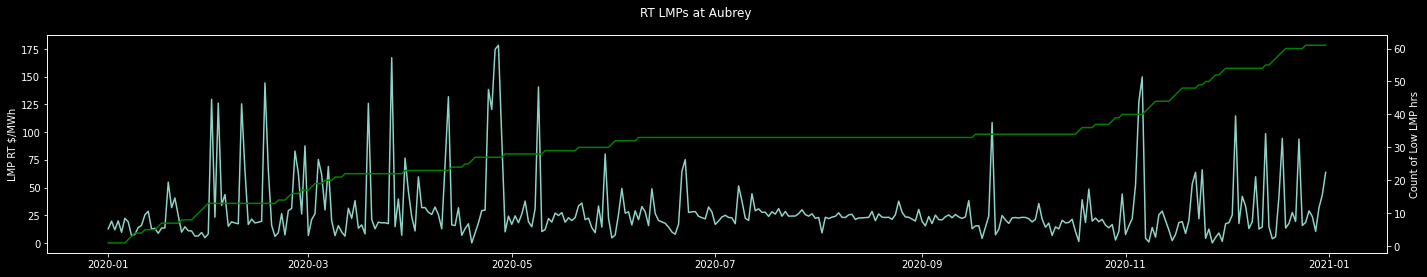

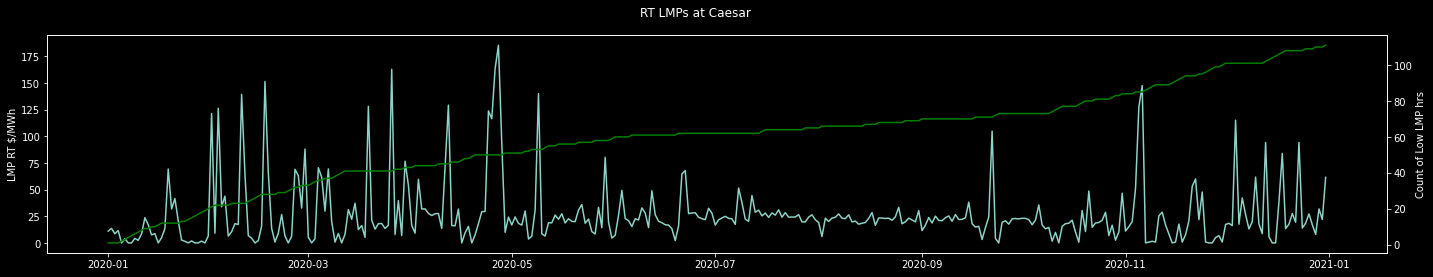

In [4]:
plot_low_lmps(summary, "Aubrey", lmp_upper)
plot_low_lmps(summary, "Caesar", lmp_upper)


In [5]:
gen_df.columns

Index(['Generator', 'Output', 'Output DA', 'Curtailment',
       'Unit Market Revenue_x', 'Unit Uplift Payment_x', 'Dispatch',
       'Dispatch DA', 'Headroom', 'Unit State', 'Unit Cost',
       'Unit Market Revenue_y', 'Unit Uplift Payment_y'],
      dtype='object')

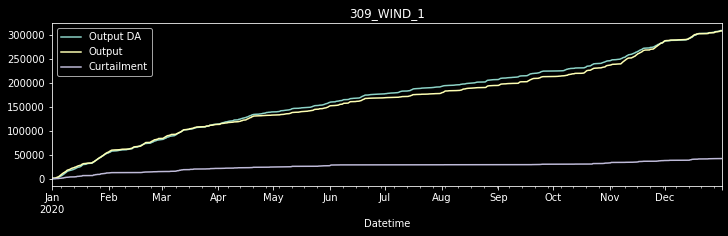

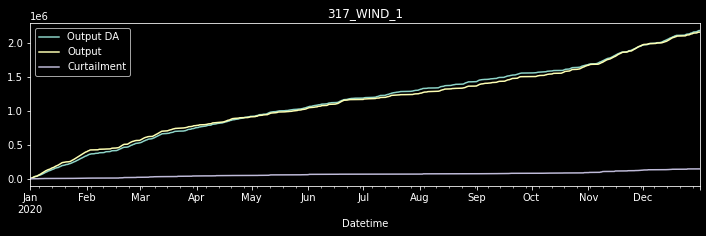

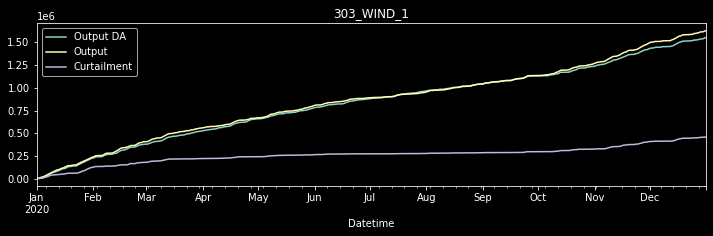

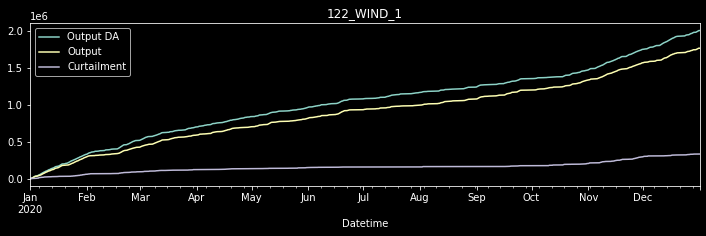

In [6]:
bus_dict = get_rtsgmlc_bus_dict(rts_gmlc.source_data_path)

wind_buses = {}
for gen in gen_df['Generator'].unique():
    if 'WIND' in gen:
        df_gen = gen_df[gen_df['Generator'] == gen][["Output DA", 'Output', 'Curtailment']]
        df_gen.cumsum().plot(figsize=(12,3), title=gen)
        wind_buses[int(gen[0:3])] = [gen]


In [7]:
for gen in gen_df['Generator'].unique():
    bus_name = bus_dict[int(gen[0:3])]
    if bus_name in wind_buses.keys():
        wind_buses[bus_name].append(gen)

wind_buses

{309: ['309_WIND_1'],
 317: ['317_WIND_1'],
 303: ['303_WIND_1'],
 122: ['122_WIND_1']}

See which gas plants are being turned on when RT prices are high

In [89]:
def get_generators_on_during_high_lmps(summary_df, lmp_lower_bd, plot=True, n_to_plot=None):
    on_when_LMP_high = {}
    for gen in gen_df['Generator'].unique():
        if "CC" in gen or "CT" in gen:
            df_gen = gen_df[gen_df['Generator'] == gen]

            bus = bus_dict[int(gen[0:3])]
            if bus not in summary_df['Bus'].unique():
                continue
            df_bus = summary_df[summary_df['Bus'] == bus]
            not_low_price_lmps = df_bus['LMP'] >= lmp_lower_bd
            on_when_LMP_high[gen] = {
                'dispatched energy' : (not_low_price_lmps * df_gen["Dispatch"].values).values,
                }
            on_when_LMP_high[gen]['dispatched timesteps'] = np.count_nonzero(on_when_LMP_high[gen]['dispatched energy'])
            on_when_LMP_high[gen]['dispatched timesteps ratio'] = on_when_LMP_high[gen]['dispatched timesteps'] / np.count_nonzero(not_low_price_lmps)
            if on_when_LMP_high[gen]['dispatched timesteps ratio'] == 0:
                on_when_LMP_high.pop(gen)

    on_when_LMP_high = {k: v for k, v in sorted(on_when_LMP_high.items(), key=lambda item: -item[1]['dispatched timesteps ratio'])}

    if not plot:
        return on_when_LMP_high

    if n_to_plot is None:
        n_to_plot = len(on_when_LMP_high)

    fig, ax = plt.subplots(1,1,figsize=(24, n_to_plot),sharex=True)
    n = 1
    ylabels = []
    for k, v in on_when_LMP_high.items():
        if n > n_to_plot:
            break
        dispatch_total = [(n_to_plot + 1 - n) if i > 0 else 0 for i in v['dispatched energy']]
        p = ax.scatter(range(len(dispatch_total)), dispatch_total, marker='.', label=k, lw=0.1)
        ylabels.insert(0, k)
        n += 1
    ax.set_ylim((0.5, None))
    ax.set_yticks(range(1, n_to_plot + 1), ylabels)
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    plt.suptitle(f"Thermal Generators Activity when LMPs > {lmp_lower_bd}")

    fig, ax = plt.subplots(8,1,figsize=(24, 8),sharex=True)
    n = 0
    for k, v in on_when_LMP_high.items():
        if n >= len(ax):
            break
        dispatch_total = (v['dispatched energy'] > 0).astype(float)
        dispatch_total *= gen_df[gen_df['Generator'] == k]['Dispatch'].values
        ax[n].plot(dispatch_total, label=k)
        ax[n].legend(bbox_to_anchor=(1.02,1), loc="upper left")
        n += 1
    
    plt.suptitle(f"Dispatch of CT generators when LMPs > {lmp_lower_bd}")

    return on_when_LMP_high

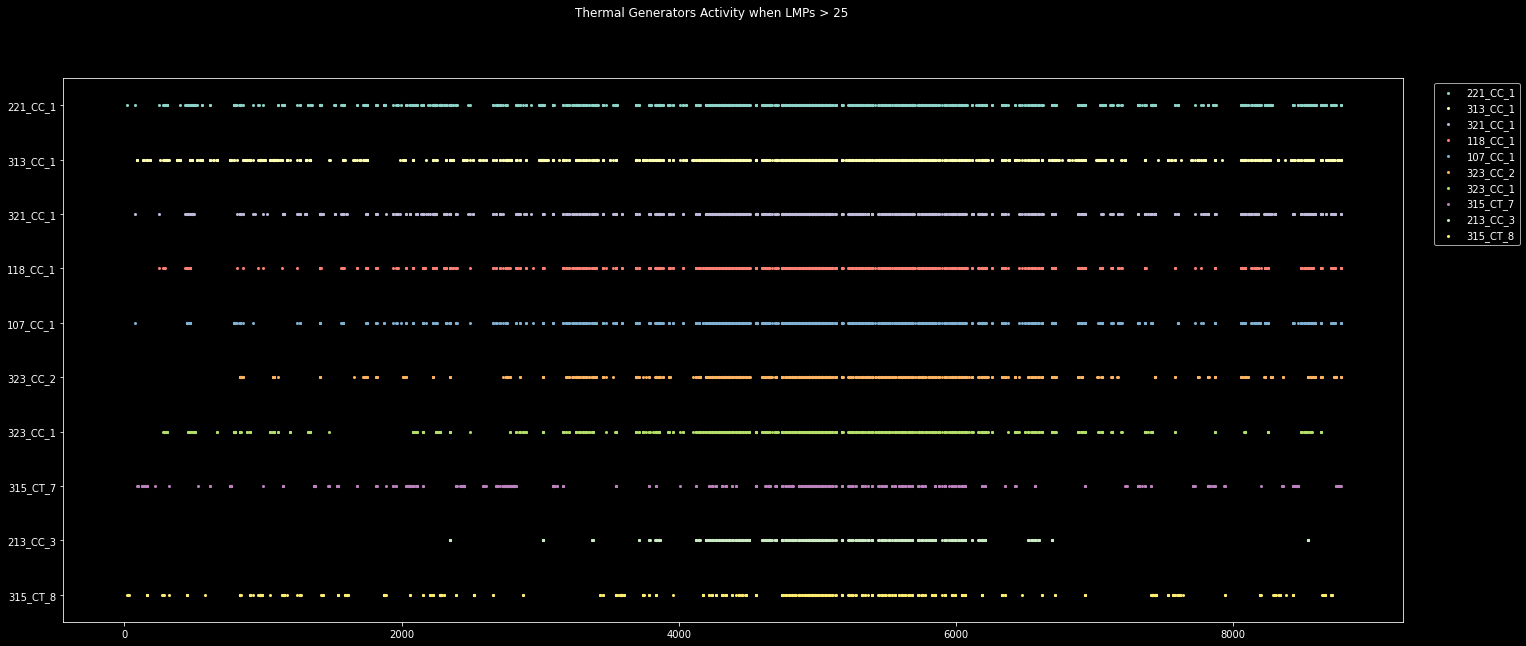

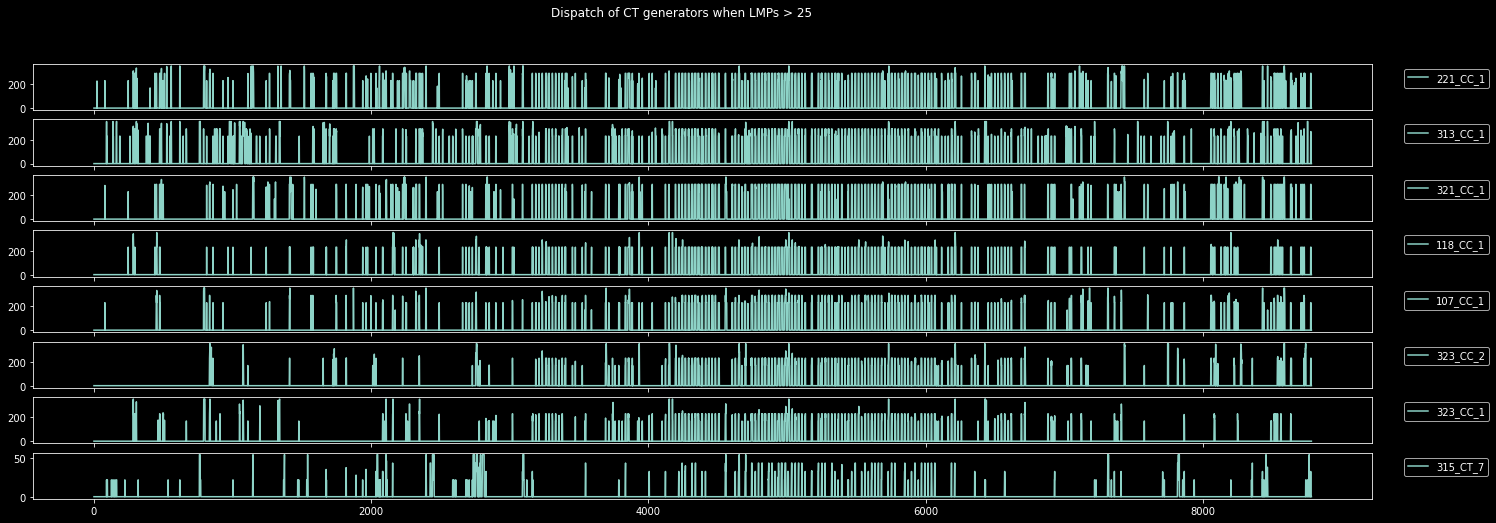

In [90]:
on_when_LMP_high = get_generators_on_during_high_lmps(summary, 25, True, 10)

Find some potential pairings of wind and gas plants that are at adjacent buses.
This way wind energy can go to the "battery + hydrogen" plant that is at the same node the gas plant, and see whether the "double loop" RT dispatch of "hybrid" Wind at Bus A + Battery & Hydrogen at Bus B == the "original" RT dispatch of Wind at Bus A + Gas at Bus B.

Even if the curtailment of wind is not due to congestions but demand, by choosing adjacent nodes and increasing the transmission capacity between them, can guarantee being able to move that energy. Will need to make the "original" the run with this transmission capacity

over-load penalty is $250/MWh

bid curves will be same as gas plant

In [39]:
branch_df, line_df, network = get_rtsgmlc_network(rts_gmlc_dir, rts_gmlc.source_data_path)


309 [303, 304, 308, 311, 312]
317 [316, 318, 322]
303 [301, 309, 324]
122 [117, 121]


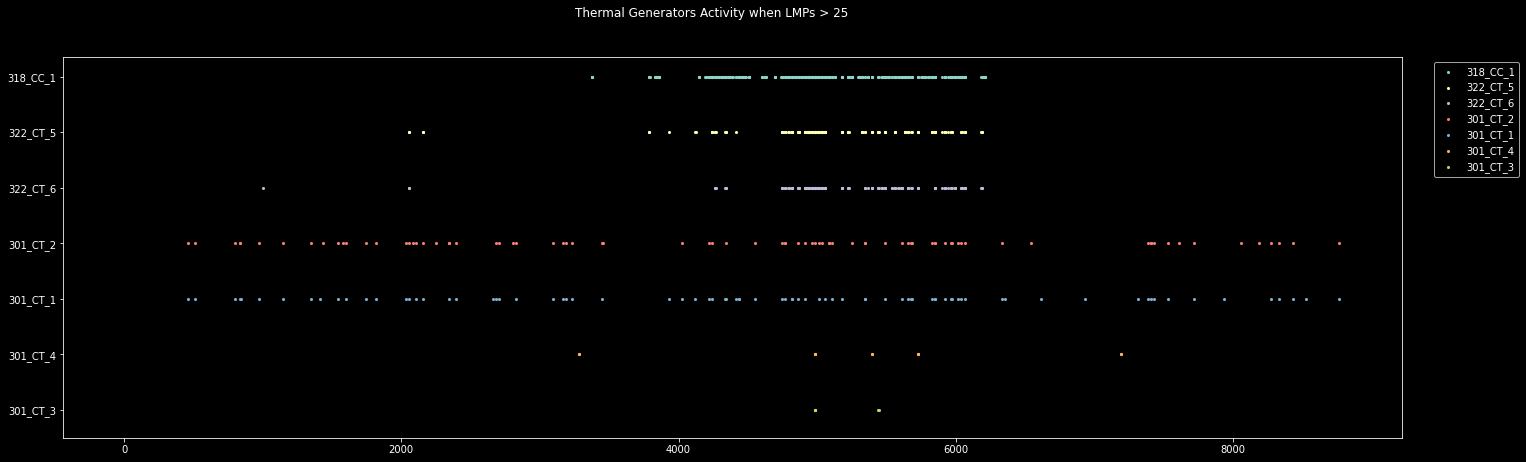

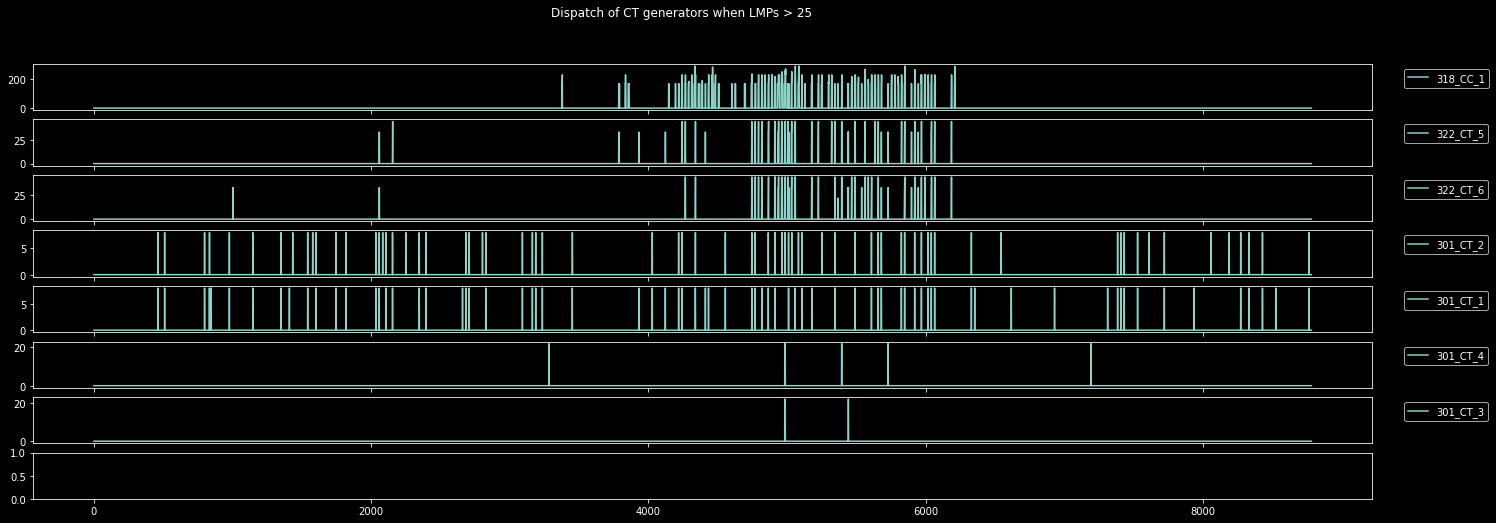

In [93]:
adj_buses = list(wind_buses.keys())
for wind_bus in wind_buses.keys():
    adj_buses.extend(network[wind_bus])
adj_buses = set(adj_buses)
adj_buses = set(bus_dict[i] for i in adj_buses)
# get_generators_on_during_high_lmps(summary[summary.Bus.isin(adj_buses)], 0, True)

tmp = summary[summary.Bus.isin(adj_buses)].copy()
adj_on_when_LMP_high = get_generators_on_during_high_lmps(tmp, 25, True)

Some potential pairs are

317_WIND_1 with 318_CC_1 or 322_CT_5 or 322_CT_6
    - has less curtailment than 303 and 309
    - Line between 317 and 318: C29. 500 MW 
    - Line between 317 and 322: C30. 500 MW

303_WIND_1 with 301_CT[1-4]
    - has a lot of curtailment
    - Line between 303 and 301: C2. This one has a lot of transmission violations, is a small line 175 MW...

In [98]:
line_df.iloc[line_df['Relative Flow'].argmax()].name
line_df[line_df['Relative Flow'] > 1]["Line"].unique()
branch_df[branch_df['From Bus'] == 317]


,From Bus,To Bus,R,X,B,Cont Rating,LTE Rating,STE Rating,Perm OutRate,Duration,Tr Ratio,Tran OutRate,Length
UID,,,,,,,,,,,,,
C29,317,318,0.002,0.014,0.030,500,600,625,0.32,11,0.0,0.2,10.0
C30,317,322,0.014,0.105,0.221,500,600,625,0.54,11,0.0,1.8,73.0


In [109]:
pairs = [[317, 318], [317, 322], [303, 301]]
for (i, j) in pairs:
    LMP_diff = (summary.query(f"Bus == '{bus_dict[i]}'")['LMP'] - summary.query(f"Bus == '{bus_dict[j]}'")['LMP']).abs()
    print((i, j), LMP_diff.max().round(2), LMP_diff.mean().round(2), LMP_diff.std().round(2), LMP_diff[LMP_diff != 0].mean().round(2), np.count_nonzero(LMP_diff))


(317, 318) 28.62 0.13 1.36 1.08 1068
(317, 322) 13.8 0.09 0.66 0.74 1068
(303, 301) 195.55 2.82 11.01 23.2 1068


In [116]:
pairs = [[309, 312], [303, 309]]
ts = []
for (i, j) in pairs:
    LMP_diff = (summary.query(f"Bus == '{bus_dict[i]}'")['LMP'] - summary.query(f"Bus == '{bus_dict[j]}'")['LMP']).abs()
    print((i, j), LMP_diff.max().round(2), LMP_diff.mean().round(2), LMP_diff.std().round(2), LMP_diff[LMP_diff != 0].mean().round(2), np.count_nonzero(LMP_diff))
    ts.append(LMP_diff[LMP_diff != 0])

(ts[0].index - ts[1].index).max()

(309, 312) 2464.0 15.42 169.5 97.59 1380
(303, 309) 12953.04 77.85 888.53 492.85 1380


Timedelta('0 days 00:00:00')

After selecting a pair of wind and gas plants, want to design a wind + battery + hydrogen IES that can emulate the combined dispatch of the two original plants, and this IES will bid as the sum of the separate original plants.

It'll be interesting to see what clues may be revealed as to how the IES can do better than as just "the sum of its parts"
 
 - Is there wind curtailment still that could be used to make green H2 for sale?

   However, adding the potential to make H2 for sale could end up reducing the ability to meet the peaker's load. In this case, how much additional wind or battery or pem capacity is optimal? Simplest thing is to do a grid search of sizes in the double loop, keeping the bid curve the same, and the hydrogen market active. Then it'll come down to how to incentivize H2 storage vs selling it all in the tracking model. May be a cleaner problem to model a "hydrogen contract" of constant H2 sales?

   LMP required to beat some H2 price? 3 $/kg * ~0.0285 kg/kWh 



 - Are there arbitrage opportunities that could be acted upon?


In [ ]:
summary.query(f"bus == {bus_dict[]}")